# Tomograph Simulation

Simple tomograph simulation for 2d pictures (*.bmp format)

### Necessary imports:

In [1]:
%matplotlib inline

In [2]:
from bresenham import bresenham
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import os
import tomograph_functions as tf
import pydicom
from pydicom.data import get_testdata_files
from ipywidgets import widgets, Layout, interact
import numpy as np

In [3]:
hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

### Main parameters to set before computing:

Basic values if not set by user:

In [4]:
hide_me
global FILE
global PATH
global detectors_num_glob
global detector_deg_glob
global iterations_glob
global new
global radius
global filtered
global mask_size

# file name of image to process *.bmp
FILE = "brain.bmp"
# localization in file system
PATH = "pictures"

# number of detectors
detectors_num_glob = 150
# angle between first and last detector
detector_deg_glob = 90
# number of iterations
iterations_glob = 360

new = []
filtered = False

In [5]:
hide_me
filename = widgets.Text()
print("Filename: ")
display(filename)
path = widgets.Text()
print("Path: ")
display(path)

a = widgets.IntSlider(min = 30, max = 90, step = 1)
bb = widgets.IntSlider(min = 5, max = 400, step = 5)
c = widgets.IntSlider(min = 5, max = 360, step = 5)
print("Angle between first and last detector: ")
display(a)
print("Number of detectors: ")
display(bb)
print("Number of iterations: ")
display(c)

confirm_button = widgets.Button(description = "Confirm parameters")

def on_button_conf(b):
    global detectors_num_glob
    global detector_deg_glob
    global iterations_glob

    detector_deg_glob = a.value
    detectors_num_glob = bb.value
    iterations_glob = c.value
    print("angle: ",  detector_deg_glob)
    print("detectors: ",  detectors_num_glob)
    print("iterations: ",  iterations_glob)


def handle_filename(sender):
    global FILE
    FILE = filename.value
    print("Filename updated !")
    
def handle_path(sender):
    global PATH
    PATH = path.value
    print("Path updated !")
    
filename.on_submit(handle_filename)
path.on_submit(handle_path)
confirm_button.on_click(on_button_conf)
display(confirm_button)

Filename: 


Text(value='')

Path: 


Text(value='')

Angle between first and last detector: 


IntSlider(value=30, max=90, min=30)

Number of detectors: 


IntSlider(value=5, max=400, min=5, step=5)

Number of iterations: 


IntSlider(value=5, max=360, min=5, step=5)

Button(description='Confirm parameters', style=ButtonStyle())

 ### Importing and showing original image:

Button(description='Load *.bmp file', style=ButtonStyle())

Button(description='Load *.dcm file', style=ButtonStyle())

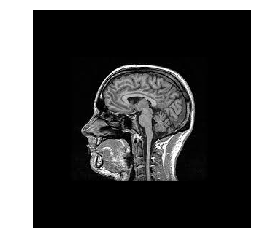

In [6]:
hide_me
bmp_button = widgets.Button(description = "Load *.bmp file")
dicom_button = widgets.Button(description = "Load *.dcm file")

def on_button_bmp(b):
    global FILE
    global PATH
    global new
    global radius
    pic_path = os.path.join(PATH, FILE)
    img = Image.open(pic_path).convert('L')
    new, radius = tf.make_square(img)
    plt.imshow(new, cmap='gray')
    plt.axis("off")
    plt.show()

def on_button_dicom(b):
    global FILE
    global PATH
    global new
    global radius
    pic_path = os.path.join(FILE)
    ds2 = pydicom.dcmread(pic_path)
    #ds2.pixel_array.shape
    np_im = ds2.pixel_array
    new_im = Image.fromarray(np_im)
    new, radius = tf.make_square(new_im)
    plt.imshow(new, cmap='gray')
    plt.axis("off")
    plt.show()
    
bmp_button.on_click(on_button_bmp)
display(bmp_button)
dicom_button.on_click(on_button_dicom)
display(dicom_button)

### Main computations

In [7]:
hide_me
def f(yes):
    global filtered
    filtered = yes

print("Do you want to add filter ??")
interact(f, yes=False)

mask_size_slide = widgets.IntSlider(min = 3, max = 10, step = 1)
print("Set size of mask: ")
display(mask_size_slide)

mask_button = widgets.Button(description = "Confirm mask size")

def on_button_mask(b):
    global mask_size
    mask_size = mask_size_slide.value
    print("Mask size: ",  mask_size)
    
mask_button.on_click(on_button_mask)
display(mask_button)

Do you want to add filter ??


interactive(children=(Checkbox(value=False, description='yes'), Output()), _dom_classes=('widget-interact',))

Set size of mask: 


IntSlider(value=3, max=10, min=3)

Button(description='Confirm mask size', style=ButtonStyle())

Mask size:  5
Mask size:  5


In [9]:
hide_me
def do_computations():
    global detectors_num_glob
    global detector_deg_glob
    global iterations_glob
    global new
    global radius
    global mask_size
    if filtered:
        return tf.process_cone_filtered(detectors_num_glob, detector_deg_glob, iterations_glob, radius, new, mask_size)
    else:
        return tf.process_cone(detectors_num_glob, detector_deg_glob, iterations_glob, radius, new)

In [10]:
out, history, sinogram, sinogram_history = do_computations()

### Image after tomograph processing:

Image after Radon transform: 


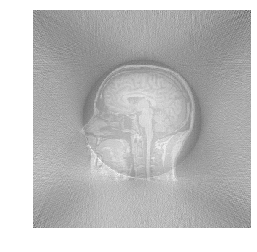

Sinogram: 


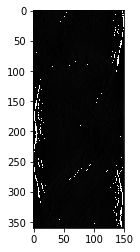

In [11]:
final_image = tf.convert_to_image(out)
sinogram_final = tf.convert_to_image(sinogram)

print("Image after Radon transform: ")
plt.imshow(final_image)
plt.axis("off")
plt.show()

print("Sinogram: ")
plt.imshow(sinogram_final,cmap='gray')
plt.show()

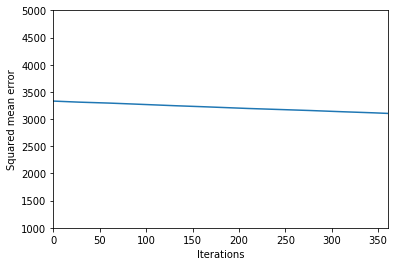

In [19]:
def plot_error(history):
    global new
    global iterations_glob
    values = []
    for frame in history:
        values.append(tf.error(new, frame, new.size[0]))
    plt.plot(range(len(values)),values)
    plt.xlabel("Iterations")
    plt.ylabel("Squared mean error")
    plt.ylim((1000, 5000))
    plt.xlim((0,len(values)))
    plt.show()

plot_error(history)

## Tomograph work animated:

In [12]:
def init():
    img.set_data([[],[]])
    return [img]

def animate(i):
    img.set_data(history[i])
    return [img]
"""
mpl.rcParams['animation.embed_limit'] = 40.0
history = tf.prepare_images(history)
fig, ax = plt.subplots()
ax.axis("off")
img = ax.imshow(history[0], cmap='gray')
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(history), interval=100)

HTML(anim.to_jshtml())
"""

'\nmpl.rcParams[\'animation.embed_limit\'] = 40.0\nhistory = tf.prepare_images(history)\nfig, ax = plt.subplots()\nax.axis("off")\nimg = ax.imshow(history[0], cmap=\'gray\')\nanim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(history), interval=100)\n\nHTML(anim.to_jshtml())\n'

## Sinogram creation animated

In [13]:
def init():
    img.set_data([[],[]])
    return [img]

def animate(i):
    img.set_data(history[i])
    return [img]

"""
mpl.rcParams['animation.embed_limit'] = 40.0
history = tf.prepare_sinograms(sinogram_history, iterations, detectors_num)
fig, ax = plt.subplots()
ax.axis("off")
img = ax.imshow(history[0])
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(history), interval=100)

HTML(anim.to_jshtml())
"""

'\nmpl.rcParams[\'animation.embed_limit\'] = 40.0\nhistory = tf.prepare_sinograms(sinogram_history, iterations, detectors_num)\nfig, ax = plt.subplots()\nax.axis("off")\nimg = ax.imshow(history[0])\nanim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(history), interval=100)\n\nHTML(anim.to_jshtml())\n'

## Save image as DICOM file:

In [14]:
filename = get_testdata_files("MR_small.dcm")[0]
ds = pydicom.dcmread(filename)

In [15]:
hide_me
name = widgets.Text()
print("Name: ")
display(name)
surname = widgets.Text()
print("Surname: ")
display(surname)
birthdate = widgets.Text()
print("Birthdate (YYYYMMDD): ")
display(birthdate)
sex = widgets.Text()
print("Sex: ")
display(sex)
weight = widgets.Text()
print("Weight: ")
display(weight)
date = widgets.Text()
print("Date of study (YYYYMMDD): ")
display(date)
comments = widgets.Text()
print("Image comments: ")
display(comments)



def handle_name(sender):
    ds.PatientName = name.value
    print("Name added, add surname !")
    
def handle_surname(sender):
    name_var = ds.PatientName
    name_var = str(name_var)
    name_var += surname.value
    ds.PatientName = name_var
    print("Name and surname updated !")

def handle_birthdate(sender):
    ds.PatientBirthDate = birthdate.value
    print("Birth Day updated !")
    
def handle_sex(sender):
    ds.PatientSex = sex.value
    print("Sex updated !")
    
def handle_date(sender):
    ds.StudyDate = date.value
    print("Date of study updated ! ")
    
def handle_weight(sender):
    ds.PatientWeight = weight.value
    print("Weight updated !")
    
def handle_comments(sender):
    ds.ImageComments = comments.value
    print("Comments updated !")
    
name.on_submit(handle_name)
surname.on_submit(handle_surname)
birthdate.on_submit(handle_birthdate)
sex.on_submit(handle_sex)
date.on_submit(handle_date)
weight.on_submit(handle_weight)
comments.on_submit(handle_comments)

Name: 


Text(value='')

Surname: 


Text(value='')

Birthdate (YYYYMMDD): 


Text(value='')

Sex: 


Text(value='')

Weight: 


Text(value='')

Date of study (YYYYMMDD): 


Text(value='')

Image comments: 


Text(value='')

In [16]:
hide_me
save_button = widgets.Button(description = "Add picture and save DICOM file",
                            layout=Layout(width='50%', height='80px'))

def on_button_clicked(b):
    im = np.array(final_image)
    ds.PixelData = im.tobytes()
    ds.Rows = final_image.size[0]
    ds.Columns = final_image.size[1]
    ds.SmallestImagePixelValue = min(map(min, im))
    ds.LargestImagePixelValue = max(map(max, im))
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0
    ds[(0x7fe0,0x0010)].is_undefined_length = False
    ds.save_as("test.dcm")
    
save_button.on_click(on_button_clicked)
display(save_button)

Button(description='Add picture and save DICOM file', layout=Layout(height='80px', width='50%'), style=ButtonS…